<a href="https://colab.research.google.com/github/adammuhtar/hrrr-vlm/blob/main/notebooks/hrrr-all-siglip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-000000?logo=github&logoColor=white&labelColor=5A5A5A)](https://github.com/adammuhtar/hrrr-vlm)

# **HRRR-ALL-SigLIP: Evaluation of SigLIP fine-tuned with multi-scale meteorological dataset**

Author: **Adam Muhtar**

This notebook provides code to run evaluations of [SigLIP](https://huggingface.co/google/siglip-base-patch16-224) model (from [Zhai et al. 2023](https://doi.ieeecomputersociety.org/10.1109/ICCV51070.2023.01100)) fine-tuned on multi-scale meteorological data; specifically the [High-Resolution Rapid Refresh (HRRR)](https://rapidrefresh.noaa.gov/hrrr/) dataset, maintained by [National Oceanic and Atmospheric Administration (NOAA)](https://www.noaa.gov).

The model in this notebook is fine-tuned on the complete multi-scale (continental- and regional-views) meteorological dataset, i.e. temperature heatmaps-weather captions of:
* Continental US
* Alaska
* [9 climatically consistent US regions](https://www.ncei.noaa.gov/access/monitoring/reference-maps/us-climate-regions): Northeast, Northern Rockies and Plains, Northwest, Ohio Valley, South, Southeast, Southwest, Upper Midwest, West.

The full repository can be accessed at: https://github.com/adammuhtar/hrrr-vlm

---

## **Table of Contents**

* [1. Notebook setup](#section-1)
* [2. Load dataset and LoRA adapter from Hugging Face](#section-2)
* [3. Retrieval quality](#section-3)
* [4. Embedding space clusters](#section-4)
  * [4.1 Agglomerative hierarchical clustering](#subsection-4-2)
  * [4.2 Uniform manifold and projection (UMAP)](#subsection-4-2)
* [5. Linear probe: Hurricane activity prediction](#section-5)

## 1. Notebook setup <a class="anchor" id="section-1"></a>

This notebook uses [Python 3.13.7](https://www.python.org/downloads/release/python-3137/) and requires the `hrrr-vlm` package to be installed. Refer to either the `pyproject.toml` or `requirements.txt` files in the root directory for the most up-to-date package dependency requirements of the `hrrr-vlm` package.

While it is possible to run this notebook on CPUs, it is advisable to run the notebook with hardware accelerators for parallel compute capabilities. We run this notebook on Apple M1 Pro chip with 16GB of RAM. Alternatively, this notebook could also be run using [Google Colab](https://colab.research.google.com/) - Google's implementation of [Jupyter Notebooks](https://jupyter.org/) - which allows users to access Tesla T4 GPU (16 GB GDDR6 @ 320 GB/s) provided for free. At the time of writing, [Google Colab](https://colab.research.google.com/)'s Python version is 3.12.11, which may mean that compatible dependency versions might differ slightly for Colab run notebooks.

## 2. Load dataset and LoRA adapter from Hugging Face <a class="anchor" id="section-2"></a>

The dataset is generated from the [High-Resolution Rapid Refresh (HRRR)](https://rapidrefresh.noaa.gov/hrrr/) dataset, maintained by [National Oceanic and Atmospheric Administration’s (NOAA)](https://www.noaa.gov).

A pre-generated version of this dataset, spanning from January 2019 to June 2025 is hosted on [Hugging Face](https://huggingface.co) under the ID [AdamMuhtar/NOAA-HRRR-HRRRAK-ALL-ImageCaption](https://huggingface.co/datasets/AdamMuhtar/NOAA-HRRR-HRRRAK-All-ImageCaption). The SigLIP model, fine-tuned on the multi-scale dataset, is also available on [Hugging Face](https://huggingface.co) under the ID [AdamMuhtar/HRRR-ALL-SigLIP](https://huggingface.co/AdamMuhtar/HRRR-ALL-SigLIP). Accessing these datasets/models may require a Hugging Face access token, which can be made for free.


How to obtain your Hugging Face access token
1. Visit [Hugging Face](https://huggingface.co) and create a free account.
2. Navigate to the [Settings](https://huggingface.co/settings/profile) page and navigate to [Access Tokens](https://huggingface.co/settings/tokens).
3. Click “New token”, give it a name, and set its role to read (sufficient for downloading datasets/models) or write (if you plan to upload or modify content).
3. Copy your newly generated token. Keep it secure—do not commit it to version control or public repositories.  

In [ ]:
from huggingface_hub import login, snapshot_download

login(token="your_hf_token_here")   # Replace with your actual Hugging Face token
snapshot_download(
    repo_id="AdamMuhtar/NOAA-HRRR-HRRRAK-ALL-ImageCaption",
    repo_type="dataset",
    local_dir="data/NOAA-HRRR-HRRRAK-ALL-ImageCaption",  # Local directory to save the dataset; change as needed
    token=True,
    allow_patterns=["captions/*.txt", "images/*.png", "*.jsonl"],
)

Fetching 7399 files: 100%|██████████| 7399/7399 [09:35<00:00, 12.86it/s]


'/Users/adammuhtar/Developer/imperial-college-london-mlds/research-project/hrrr-vlm/data/NOAA-HRRR-HRRRAK-ALL-ImageCaption'

In [ ]:
snapshot_download(
    repo_id="AdamMuhtar/HRRR-ALL-SigLIP",
    repo_type="model",
    local_dir="models/HRRR-ALL-SigLIP",  # Local directory to save the model; change as needed
    token=True,
    allow_patterns=["*.json", "*.safetensors"],
)

Fetching 2 files: 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]


'/Users/adammuhtar/Developer/imperial-college-london-mlds/research-project/hrrr-vlm/scripts/models/HRRR-ALL-SigLIP'

## 3. Retrieval quality <a class="anchor" id="section-3"></a>

[SigLIP](https://huggingface.co/google/siglip-base-patch16-224) model (from [Zhai et al. 2023](https://doi.ieeecomputersociety.org/10.1109/ICCV51070.2023.01100)) is a class of dual-encoder (vision and text) models with late fusion based on CLIP (from [Radford et al. 2021](https://proceedings.mlr.press/v139/radford21a.html)).

A key use-case of encoder-based transformer models are in information retrieval of unstructured data (e.g. texts, images, audio, etc.). Retrieval capability is therefore a key quality to measure. We evaluate the model's retrieval performance along three key information retrieval metrics:
* Recall@K: Measures whether the correct item is found within the top K results.
  * "Out of the top K retrieved items, did the model manage to include the right answer?”"
* Mean reciprocal rank (MRR): Looks at the position of the first correct item, the earlier it appears, the higher the score.
  * "How close to the top is the first correct answer?"
* Normalised Discounted Cumulative Gain (NDCG): Considers not just whether relevant items are found, but also how highly ranked they are, giving more weight to correct results near the top.
  * "Are the most relevant answers ranked near the top of the list?"

In [ ]:
from pathlib import Path

from hrrr_vlm.train.train import (
    HRRRLoRASigLIPTrainer,
    ModelTrainingConfig,
    training_init,
)
from hrrr_vlm.utils.logger import configure_logger

# Configure logger
logger = configure_logger()

# Initialise training configuration and trainer
training_init()
config = ModelTrainingConfig(
    num_epochs=20,
    learning_rate=1e-4,
    batch_size=32,
    train_split=0.8,
    val_split=0.15,
    test_split=0.05,
    num_workers=0,
    max_length=512,
)
trainer = HRRRLoRASigLIPTrainer(
    model_name="google/siglip-base-patch16-224",
    lora_config={
        "r": 32,
        "lora_alpha": 64,
        "target_modules": ["q_proj", "k_proj", "v_proj", "out_proj"],
        "lora_dropout": 0.05,
        "bias": "none",
    },
)
trainer.setup_model()

# Create data loaders; change paths as needed
parent_dir = Path.cwd().parent.resolve()
jsonl_path = parent_dir / "data" / "NOAA-HRRR-HRRRAK-All-ImageCaption" / "training_dataset.jsonl"
images_path = parent_dir / "data" / "NOAA-HRRR-HRRRAK-All-ImageCaption" / "images"
adapter_path = parent_dir / "models" / "HRRR-ALL-SigLIP"
train_loader, val_loader, test_loader = trainer.create_data_loaders(
    data_file=jsonl_path, images_dir=images_path, config=config
)
trainer.load_model(model_path=adapter_path)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]


In [ ]:
from hrrr_vlm.eval.retrieval import RetrievalEvaluator

evaluator = RetrievalEvaluator(trainer=trainer)
retrieval_results = evaluator.evaluate_retrieval(
    dataloader=test_loader, max_samples=None
)
retrieval_results._asdict()

Extracting embeddings: 100%|██████████| 6/6 [00:19<00:00,  3.20s/it]


{'i2t_recall_at_1': 0.9731182795698925,
 'i2t_recall_at_5': 1.0,
 'i2t_recall_at_10': 1.0,
 't2i_recall_at_1': 0.9838709677419355,
 't2i_recall_at_5': 1.0,
 't2i_recall_at_10': 1.0,
 'mean_recall_at_1': 0.978494623655914,
 'mean_recall_at_5': 1.0,
 'mean_recall_at_10': 1.0,
 'i2t_mrr': 0.9865591397849462,
 't2i_mrr': 0.9919354838709677,
 'mean_mrr': 0.989247311827957,
 'i2t_ndcg_at_5': 0.8738975361405575,
 'i2t_ndcg_at_10': 0.8191467186084975,
 't2i_ndcg_at_5': 0.8694167233547648,
 't2i_ndcg_at_10': 0.8199490358417089,
 'mean_ndcg_at_5': 0.8716571297476612,
 'mean_ndcg_at_10': 0.8195478772251032}

## 4. Embedding space clusters <a class="anchor" id="section-4"></a>

Outside of retrieval quality, we also assess the emergent geometry of the learned latent space. We observe the structure of embeddings generated with the following methods:
* The structure formed under agglomerative hierarchical clustering, via dendrograms, and visualise the groups formed by the embeddings by regions and seasons.
* The general structure formed under uniform manifold and projection (UMAP). 

### 4.1 Agglomerative hierarchical clustering (dendrograms) <a class="anchor" id="subsection-4-1"></a>

In [7]:
from hrrr_vlm.eval.embeddings import EmbeddingExtractor

# Extract embeddings
extractor = EmbeddingExtractor(trainer)
embedding_data = extractor.extract_embeddings_with_metadata(
    train_loader, max_samples=5000, normalise=True
)

Extracting embeddings: 100%|██████████| 92/92 [05:28<00:00,  3.57s/it]


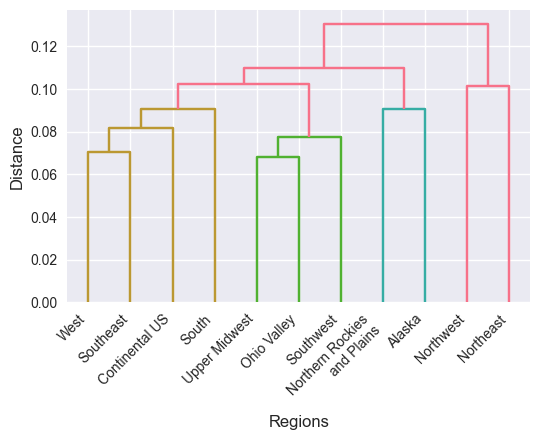

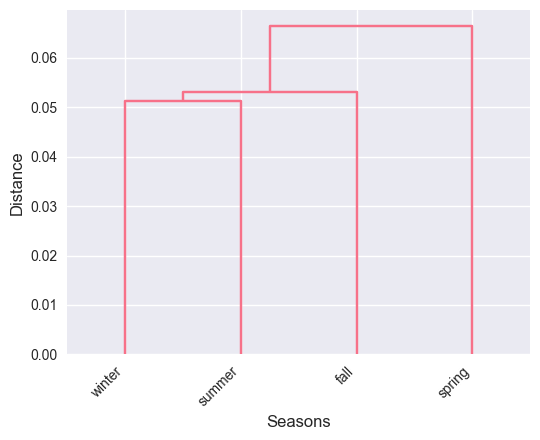

In [ ]:
from hrrr_vlm.eval.dendrograms import DendrogramGenerator

dendrogram_generator = DendrogramGenerator()

# Generate regional patterns dendrogram
regional_analysis = dendrogram_generator.create_regional_dendrogram(
    embedding_data,
    embedding_type="combined",
    linkage_method="ward",
    save_path="regional_patterns.png",
)

# Generate seasonal patterns dendrogram
seasonal_analysis = dendrogram_generator.create_seasonal_dendrogram(
    embedding_data,
    embedding_type="combined",
    linkage_method="ward",
    save_path="seasonal_patterns.png",
)

### 4.2 Uniform manifold and projection (UMAP) <a class="anchor" id="subsection-4-2"></a>

In [10]:
import matplotlib.pyplot as plt

from hrrr_vlm.eval.visualisation import EmbeddingClusterer

# Initialize 3D clustering with UMAP
clusterer_3d = EmbeddingClusterer(
    random_state=42,
    reduction_method="umap",
    n_components=3,  # 3D embeddings
)

# Find optimal clusters for 3D
optimal_analysis_3d = clusterer_3d.find_optimal_clusters(
    embedding_data, embedding_type="combined", k_range=(2, 10)
)
optimal_k_3d = optimal_analysis_3d["optimal_k"]["silhouette"]

# Perform clustering on both embedding types
kmeans_image_3d = clusterer_3d.cluster_kmeans(
    embedding_data, n_clusters=optimal_k_3d, embedding_type="image"
)
kmeans_text_3d = clusterer_3d.cluster_kmeans(
    embedding_data, n_clusters=optimal_k_3d, embedding_type="text"
)

/Users/adammuhtar/Developer/imperial-college-london-mlds/research-project/hrrr-vlm/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


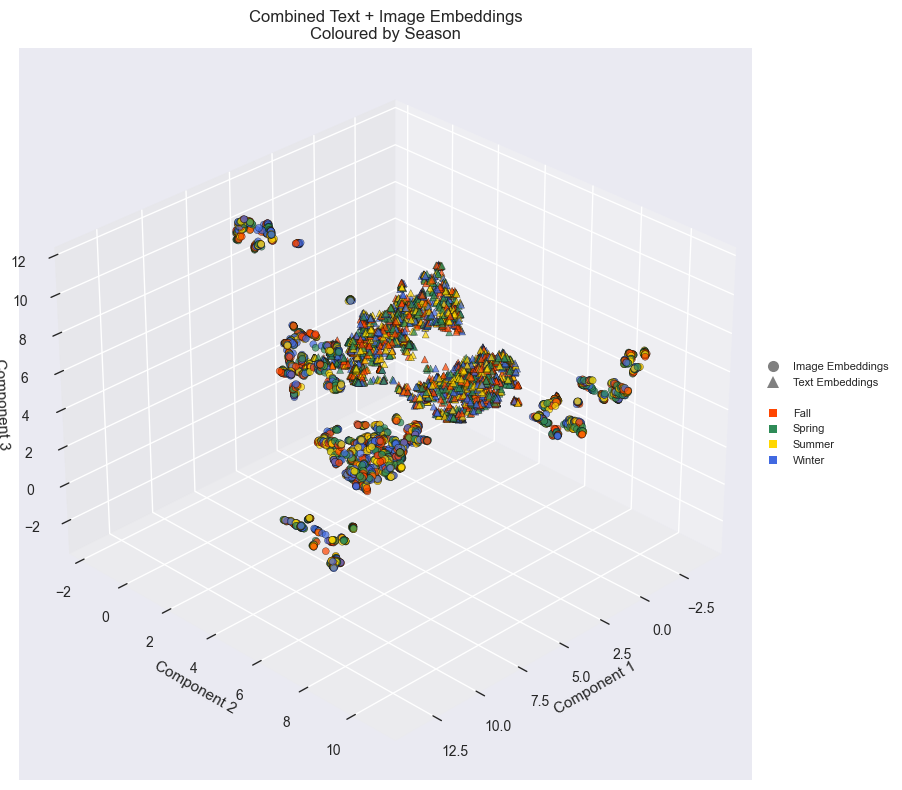

In [11]:
# Visualisation of Text + Image Embeddings by Season
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Get data
reduced_emb_img = kmeans_image_3d.reduced_embeddings
reduced_emb_txt = kmeans_text_3d.reduced_embeddings
metadata = embedding_data.metadata

# Extract season info
season_colors = {
    "spring": "#2E8B57",  # Sea green
    "summer": "#FFD700",  # Gold
    "fall": "#FF4500",  # Orange red
    "winter": "#4169E1",  # Royal blue
}
seasons = [meta.get("season", "Unknown") for meta in metadata]
colors = [season_colors.get(season, "#808080") for season in seasons]

# Plot image embeddings (circles)
scatter_img = ax.scatter(
    reduced_emb_img[:, 0],
    reduced_emb_img[:, 1],
    reduced_emb_img[:, 2],
    c=colors,
    alpha=0.7,
    s=25,
    marker="o",
    edgecolors="black",
    linewidth=0.3,
    label="Image Embeddings",
)

# Plot text embeddings (triangles)
scatter_txt = ax.scatter(
    reduced_emb_txt[:, 0],
    reduced_emb_txt[:, 1],
    reduced_emb_txt[:, 2],
    c=colors,
    alpha=0.7,
    s=25,
    marker="^",
    edgecolors="black",
    linewidth=0.3,
    label="Text Embeddings",
)

# Build legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="gray",
        markersize=8,
        label="Image Embeddings",
    ),
    plt.Line2D(
        [0],
        [0],
        marker="^",
        color="w",
        markerfacecolor="gray",
        markersize=8,
        label="Text Embeddings",
    ),
    plt.Line2D([0], [0], linestyle="-", color="white", label=""),  # separator
]

# Add season colors
unique_seasons = sorted(set(seasons))
legend_elements.extend(
    plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        markerfacecolor=season_colors.get(season, "#808080"),
        markersize=6,
        label=season.capitalize(),
    )
    for season in unique_seasons
)

ax.legend(
    handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8
)

# Labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("Combined Text + Image Embeddings\nColoured by Season")
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()


## 5. Linear probe: Hurricane activity prediction <a class="anchor" id="section-5"></a>

Following the linear probe protocol in [Radford et al. (2021)](https://proceedings.mlr.press/v139/radford21a.html), we train a logistic regression to predict hurricane activity using image embeddings generated by the (frozen) vision encoder from our fine-tuned model as features.

By freezing the encoder and fitting only a single linear logistic regression classifier, we test whether the learned embeddings already place temperature maps so that a single hyperplane separates "hurricane within 3 days" from "no hurricane"—attributing performance to representation quality from the learned latent space rather than classifier capacity ([Alain & Bengio, 2017](https://openreview.net/forum?id=HJ4-rAVtl)).

In [ ]:
from pathlib import Path

from hrrr_vlm.eval.linear_probe import filter_embeddings_by_date, run_linear_probe_analysis

# Define paths; change as needed
hurricane_csv_path = Path.cwd().parent.resolve() / "data" / "hurricane_activity.csv"
output_dir = "./linear_probe_hrrr_all_results"

# Filter the embedding data to match hurricane dataset timeframe
filtered_embedding_data = filter_embeddings_by_date(embedding_data, cutoff_date="2025-05-31")

# Run linear probe analysis
results = run_linear_probe_analysis(
    embedding_data=filtered_embedding_data,
    hurricane_csv_path=hurricane_csv_path,
    output_dir=output_dir,
    lookahead_days=3,
)

# Print results
for model_name, r in results.items():
    print(f"{model_name}:")
    print(f"AUC-ROC: {r.auc_roc:.3f}")

linear_probe:
AUC-ROC: 0.915


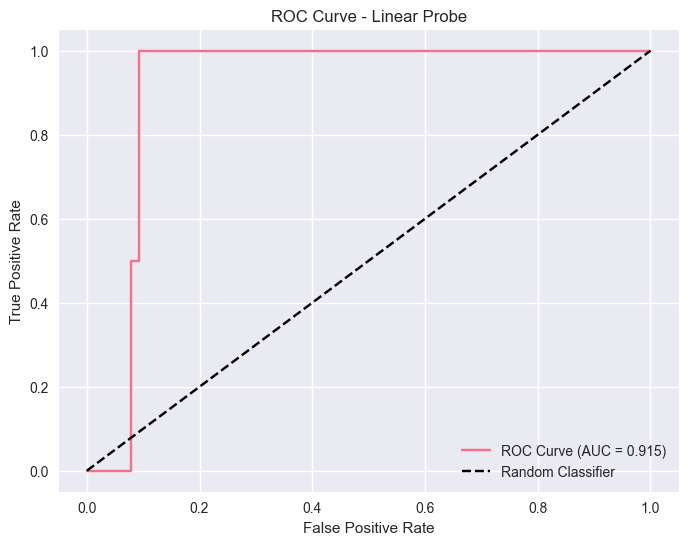

In [15]:
import polars as pl

# Load ROC curve data
results_path = Path(output_dir) / "linear_probe_results.roc_curve.csv"
roc_data = pl.read_csv(results_path)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    roc_data["false_positive_rate"],
    roc_data["true_positive_rate"],
    label=f"ROC Curve (AUC = {roc_data['auc_roc'][0]:.3f})",
)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear Probe")
plt.legend()
plt.grid(True)
plt.show()
